
# Latent Dirichlet Allocation(LDA) for 'Customer interest' modelling


#### Import libraries

In [1]:
# !pip install pyLDAvis 

In [2]:
# import libraries 
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
import gensim
from gensim import corpora

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


####   Dataset Analysis

In [4]:
# Read data from csv
customer_review_data= pd.read_csv("E:\\code\\SENETIMENT_ANALYSIS_AMAZON\\LDACustomerInterviewsModelling\\amazon_alexa - amazon_alexa.csv")
print(customer_review_data.head(2))
print(len(customer_review_data))
print('Number of Unique variation')
print(len(customer_review_data.groupby('variation')))

   rating       date        variation verified_reviews  feedback
0       5  31-Jul-18  Charcoal Fabric    Love my Echo!         1
1       5  31-Jul-18  Charcoal Fabric        Loved it!         1
3150
Number of Unique variation
16


In [5]:
# Clean text
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    return text2.lower()

In [6]:
# In natural language processing, useless words (data), are referred to as stop words. 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Removes the rows that contains NULL values.
customer_review_data.dropna(axis = 0, how ='any',inplace=True) 

####   Filter short reviews according to rating

In [8]:
customer_review_data['verified_reviews'] = customer_review_data['verified_reviews'].apply(clean_text)
customer_review_data['Num_words_text'] = customer_review_data['verified_reviews'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(customer_review_data['rating'].value_counts())
print(len(customer_review_data))
print('-------------------------')
max_review_data_sentence_length  = customer_review_data['Num_words_text'].max()

mask = (customer_review_data['Num_words_text'] < 100) & (customer_review_data['Num_words_text'] >=20)
df_short_reviews = customer_review_data[mask]
df_new = df_short_reviews.groupby('rating').apply(lambda x: x.sample(n=40)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

-------Dataset --------
5    2246
4     447
1     146
3     140
2      92
Name: rating, dtype: int64
3071
-------------------------
No of Short reviews
640


In [9]:
df_short_reviews

,rating,date,variation,verified_reviews,feedback,Num_words_text
2,4,31-Jul-18,Walnut Finish,sometimes while playing game answer question c...,1,21
6,3,31-Jul-18,Sandstone Fabric,without having cellphone cannot many features ...,1,33
7,5,31-Jul-18,Charcoal Fabric,think this purchased working getting every roo...,1,22
12,5,30-Jul-18,Oak Finish,purchased this mother having knee problems giv...,1,30
17,5,30-Jul-18,Heather Gray Fabric,have only been using alexa couple days having ...,1,21
...,...,...,...,...,...,...
3101,5,30-Jul-18,Black Dot,these additional alexa based devices make acce...,1,27
3110,5,30-Jul-18,White Dot,love personally prefer spotify music it’s grea...,1,46
3129,4,30-Jul-18,White Dot,have these throughout home they great there ti...,1,38
3147,5,30-Jul-18,Black Dot,love these things have them running entire hom...,1,49


In [10]:
df_new

,rating,date,variation,verified_reviews,feedback,Num_words_text
0,1,10-Jun-18,Black,impressed does save groups correctly understan...,0,24
1,1,29-Jul-18,Black Show,bought this product hoping that alexa would pr...,0,94
2,1,30-Jul-18,Black Dot,really happy with original echo thought echo b...,0,68
3,1,20-Jul-18,Black Plus,only purchase echo plus because built came wit...,0,58
4,1,11-Jun-18,White,very this device don’t know it’s because refur...,0,23
...,...,...,...,...,...,...
195,5,30-Jul-18,Charcoal Fabric,love love this little gadget made lives much e...,1,31
196,5,30-Jul-18,White Dot,only complaint have that sound quality isnt gr...,1,43
197,5,29-Jul-18,Black Show,originally show video chat family members work...,1,26
198,5,29-Jun-18,Black Plus,have great time using this family even toddler...,1,21


####   Dataset Pre-processing

In [11]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_new['verified_reviews']=df_new['verified_reviews'].apply(remove_stopwords)

In [12]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
# create a lemmatization for filtering
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

#### Finding Nouns and Adjectives

In [13]:
text_list=df_new['verified_reviews'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

bought product hoping alexa would pretty well developed enough along therefore expecting responsive piece crap doesnt even know respond question amazon told echo buttons manual step device potential given screen decent sound bucks would never reccomend even spent feel like shorted lastly device pretty useless without prime membership linked personal account thing literally decorated bluetooth speaker went family account work minimal even prime membership music pass something thats extra month leaving item subscription nightmare overpriced decorated bluetooth speaker eyes would give zero stars could
['product', 'responsive', 'piece', 'crap', 'respond', 'question', 'button', 'manual', 'step', 'device', 'potential', 'screen', 'decent', 'sound', 'buck', 'feel', 'shorted', 'lastly', 'device', 'useless', 'prime', 'membership', 'personal', 'account', 'thing', 'speaker', 'family', 'account', 'work', 'minimal', 'prime', 'membership', 'music', 'extra', 'month', 'item', 'subscription', 'nightmare

#### Dictionary and Document term matrix

In [14]:
# Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

####  LDA model

In [15]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [16]:
# Build LDA model
num_topics=34
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=10,
                chunksize=1000, passes=50,iterations=100)

In [17]:
lda_model.print_topics(num_topics)

[(0,
  '0.021*"time" + 0.021*"site" + 0.021*"occasion" + 0.021*"process" + 0.021*"rare" + 0.021*"stream" + 0.021*"title" + 0.021*"unable" + 0.021*"firestick" + 0.021*"disappointing"'),
 (1,
  '0.035*"free" + 0.026*"issue" + 0.026*"bulb" + 0.026*"purchase" + 0.026*"need" + 0.018*"platform" + 0.018*"nice" + 0.018*"thing" + 0.018*"area" + 0.018*"price"'),
 (2,
  '0.021*"device" + 0.021*"time" + 0.021*"fault" + 0.021*"smart" + 0.021*"work" + 0.021*"great" + 0.021*"right" + 0.011*"speaker" + 0.011*"equipment" + 0.011*"well"'),
 (3,
  '0.035*"weather" + 0.035*"morning" + 0.024*"satisfied" + 0.024*"music" + 0.024*"wifi" + 0.024*"well" + 0.024*"learning" + 0.024*"inexpensive" + 0.024*"error" + 0.024*"mother"'),
 (4,
  '0.019*"function" + 0.019*"technology34" + 0.019*"suggestion" + 0.019*"lighting" + 0.019*"clock" + 0.019*"weather" + 0.019*"local" + 0.019*"apartment" + 0.019*"sleek" + 0.019*"scroll"'),
 (5,
  '0.031*"volume" + 0.031*"increase" + 0.031*"decrease" + 0.023*"alexa" + 0.023*"show" +

#### Measureing the model

In [18]:
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=100))

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)



Perplexity:  -8.965861173538014

Coherence Score: 0.41439976708442644


#### Visualize the topics

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26     0.155466 -0.117502       1        1  8.064452
14     0.093814 -0.069310       2        1  7.102653
13     0.132606  0.020310       3        1  5.584862
30     0.127141  0.076582       4        1  4.872272
6      0.059197  0.210278       5        1  4.831071
27     0.082713 -0.013261       6        1  4.417321
31     0.087293 -0.060417       7        1  4.319581
32     0.054960  0.021356       8        1  3.737903
22    -0.017648  0.138655       9        1  3.693270
21     0.078916  0.032689      10        1  3.465698
24    -0.094529  0.021045      11        1  3.344124
33     0.004688 -0.076290      12        1  3.298951
5     -0.031541  0.038430      13        1  3.279584
7      0.058996  0.066123      14        1  3.121852
8      0.035840 -0.022164      15        1  3.046474
18    -0.051947 -0.032426      16        1  3.040526
28     0.038975 -0.023748      17        1  2.896910
1     -0.023723 -0.066361      18        1  2.817854
15     0.086260  0.023343      19        1  2.740113
10     0.025651 -0.116304      20        1  2.611009
9      0.085809  0.031540      21        1  2.483543
17    -0.023462 -0.016108      22        1  2.414743
2     -0.000578 -0.043192      23        1  2.137287
23    -0.072321 -0.012873      24        1  2.032452
3     -0.041158  0.025431      25        1  1.907248
25    -0.089969 -0.111091      26        1  1.870022
29    -0.103046  0.063777      27        1  1.234164
11    -0.048816 -0.029459      28        1  1.199520
4     -0.106023  0.007694      29        1  0.943905
20    -0.091493  0.006512      30        1  0.861066
19    -0.091129  0.047285      31        1  0.854039
16    -0.098412 -0.017677      32        1  0.816965
0     -0.119400  0.007577      33        1  0.785232
12    -0.103128 -0.010442      34        1  0.173333, topic_info=          Term       Freq      Total Category  logprob  loglift
37      screen  26.000000  26.000000  Default  30.0000  30.0000
16      device  58.000000  58.000000  Default  29.0000  29.0000
27       music  67.000000  67.000000  Default  28.0000  28.0000
7         time  41.000000  41.000000  Default  27.0000  27.0000
170      great  36.000000  36.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
25     minimal   0.005736   1.519305  Topic34  -6.8533   0.7785
26       month   0.005736  11.992578  Topic34  -6.8533  -1.2875
27       music   0.005736  67.074575  Topic34  -6.8533  -3.0090
28   nightmare   0.005736   1.519305  Topic34  -6.8533   0.7785
29    personal   0.005736   2.125047  Topic34  -6.8533   0.4430

[1639 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
797      22  0.686395    24ghz
678      27  0.757792    342nd
333       8  0.870127     34im
196      26  0.473548    34the
112       4  0.646810  34thing
...     ...       ...      ...
332      11  0.317011  youtube
332      17  0.317011  youtube
111       7  0.653550     zzzz
864      32  0.814689        ’
256       7  0.653552      ’ve

[2031 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 15, 14, 31, 7, 28, 32, 33, 23, 22, 25, 34, 6, 8, 9, 19, 29, 2, 16, 11, 10, 18, 3, 24, 4, 26, 30, 12, 5, 21, 20, 17, 1, 13])

#### Finding the best model 

In [20]:
# Compute c_v coherence for various number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

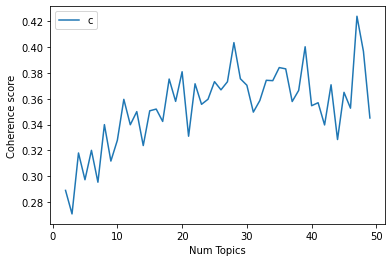

In [22]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [23]:
# Print the coherence scores
max_coherence=0
optimal_topics=0
index_model=0
i=0
for m, cv in zip(x, coherence_values):
    if(max_coherence<cv):
        index_model=i
        max_coherence=cv
        optimal_topics=m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    i+=1
    
print("\n_____________________________________________________")   
print(index_model," :: "+"Optimal Topic number =", optimal_topics, " Coherence Scores =", round(max_coherence, 4))

Num Topics = 2  has Coherence Value of 0.2892
Num Topics = 3  has Coherence Value of 0.271
Num Topics = 4  has Coherence Value of 0.3181
Num Topics = 5  has Coherence Value of 0.2974
Num Topics = 6  has Coherence Value of 0.3201
Num Topics = 7  has Coherence Value of 0.2955
Num Topics = 8  has Coherence Value of 0.34
Num Topics = 9  has Coherence Value of 0.3118
Num Topics = 10  has Coherence Value of 0.3279
Num Topics = 11  has Coherence Value of 0.3595
Num Topics = 12  has Coherence Value of 0.3399
Num Topics = 13  has Coherence Value of 0.35
Num Topics = 14  has Coherence Value of 0.3238
Num Topics = 15  has Coherence Value of 0.3506
Num Topics = 16  has Coherence Value of 0.352
Num Topics = 17  has Coherence Value of 0.3424
Num Topics = 18  has Coherence Value of 0.3752
Num Topics = 19  has Coherence Value of 0.3579
Num Topics = 20  has Coherence Value of 0.3808
Num Topics = 21  has Coherence Value of 0.331
Num Topics = 22  has Coherence Value of 0.3715
Num Topics = 23  has Coheren

In [24]:
# Select the model and print the topics
optimal_model = model_list[index_model]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(30,
  '0.041*"need" + 0.029*"volume" + 0.029*"decrease" + 0.029*"increase" + 0.027*"able" + 0.015*"english" + 0.015*"amazon" + 0.015*"college" + 0.015*"wife" + 0.015*"boring"'),
 (2,
  '0.082*"music" + 0.048*"prime" + 0.024*"great" + 0.019*"information" + 0.019*"family" + 0.019*"ability" + 0.019*"search" + 0.019*"home" + 0.019*"sound" + 0.019*"free"'),
 (28,
  '0.023*"voice" + 0.023*"worth" + 0.023*"excitement" + 0.023*"time" + 0.012*"colon" + 0.012*"minute" + 0.012*"dish" + 0.012*"living" + 0.012*"receiver" + 0.012*"stand"'),
 (6,
  '0.041*"free" + 0.041*"card" + 0.031*"bulb" + 0.029*"software" + 0.020*"homescreen" + 0.020*"once34" + 0.020*"purchase" + 0.020*"product" + 0.020*"device" + 0.017*"reception"'),
 (5,
  '0.058*"device" + 0.048*"music" + 0.032*"sound" + 0.030*"thing" + 0.020*"product" + 0.019*"love" + 0.019*"stick" + 0.019*"sling" + 0.016*"well" + 0.016*"quality"'),
 (43,
  '0.026*"work" + 0.026*"button" + 0.026*"ring" + 0.017*"skill" + 0.017*"volume" + 0.017*"great" + 0.0

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
40    -0.104418 -0.004898       1        1  5.115965
45    -0.089134 -0.026638       2        1  4.644196
19    -0.088570  0.138147       3        1  4.566510
24     0.047277 -0.064997       4        1  3.390977
13    -0.048752 -0.106308       5        1  3.201660
26    -0.097986  0.044024       6        1  3.168735
2     -0.115995  0.024219       7        1  3.136308
12    -0.098266  0.005275       8        1  3.134289
43    -0.011034 -0.114184       9        1  3.072366
10    -0.095350  0.130456      10        1  3.024680
16     0.021569 -0.011267      11        1  3.018933
33    -0.076436  0.047570      12        1  2.854571
15    -0.068674 -0.071909      13        1  2.785901
36    -0.130113 -0.011293      14        1  2.750578
7     -0.148177 -0.029088      15        1  2.741727
39    -0.039434 -0.070802      16        1  2.691051
5     -0.065072 -0.068915      17        1  2.658528
41    -0.093519  0.034298      18        1  2.612906
6      0.038676 -0.095332      19        1  2.554030
1      0.026739 -0.029963      20        1  2.378571
37    -0.105742  0.122158      21        1  2.325217
31    -0.056410 -0.102159      22        1  2.271070
9     -0.043456 -0.028122      23        1  2.243292
23    -0.082223 -0.079952      24        1  2.206955
20     0.002152  0.012025      25        1  2.181486
44     0.004462 -0.050144      26        1  2.180001
28     0.073698  0.038876      27        1  2.112525
30     0.038785  0.023462      28        1  2.112325
34     0.029624 -0.003434      29        1  1.922113
8      0.002432  0.186283      30        1  1.662983
25     0.114886 -0.058412      31        1  1.563859
42     0.130300  0.047439      32        1  1.532005
46     0.051475 -0.058164      33        1  1.482622
21     0.057069  0.020794      34        1  1.437724
22    -0.009150 -0.003925      35        1  1.286594
38     0.084566 -0.024251      36        1  1.154292
35     0.055007  0.021367      37        1  1.154197
0      0.084775 -0.032178      38        1  1.120238
14     0.090662  0.056945      39        1  0.963992
3      0.106008  0.020637      40        1  0.959580
29     0.083030 -0.042968      41        1  0.733163
32     0.097239  0.017360      42        1  0.605888
11     0.042649  0.066634      43        1  0.455638
18     0.082704  0.020723      44        1  0.453587
27     0.077064  0.042243      45        1  0.125390
17     0.112531  0.034183      46        1  0.125390
4      0.112531  0.034183      47        1  0.125390, topic_info=         Term      Freq      Total Category  logprob  loglift
16     device  56.00000  56.000000  Default  30.0000  30.0000
37     screen  25.00000  25.000000  Default  29.0000  29.0000
27      music  67.00000  67.000000  Default  28.0000  28.0000
40    speaker  29.00000  29.000000  Default  27.0000  27.0000
33    product  31.00000  31.000000  Default  26.0000  26.0000
..        ...       ...        ...      ...      ...      ...
25    minimal   0.00415   1.618832  Topic47  -6.8533   0.7151
26      month   0.00415  12.864364  Topic47  -6.8533  -1.3577
27      music   0.00415  67.297718  Topic47  -6.8533  -3.0124
28  nightmare   0.00415   1.602209  Topic47  -6.8533   0.7254
29   personal   0.00415   2.362559  Topic47  -6.8533   0.3370

[2155 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
279       2  0.654799   1030pm
797      11  0.632819    24ghz
678       8  0.690414    342nd
333       1  0.823204     34im
196      32  0.482440    34the
...     ...       ...      ...
332      31  0.312955  youtube
494       2  0.654812    zwave
111       1  0.633497     zzzz
864      10  0.638848        ’
256      15  0.724404      ’ve

[2361 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[41, 46, 20, 25, 14, 27, 3, 13, 44, 11, 17, 34, 16, 37, 8, 40, 6, 42, 7

#### Predict new review using trained model

In [40]:
# Enter customer review
input_review="I was a little nervous when I received my new Echo as I'm not really Tech savvy. I found it a bit intimidating at first but it didn't take me to long to figure it out!! I'm very happy with my purchase and now thinking of adding an echo spot!!!"

In [41]:
# Predicting the topic distribution for the given review
input_testing_review_list=[""]
input_testing_review_list[0]=input_review
tokenized_testing_reviews = lemmatization(input_testing_review_list)
# print(tokenized_testing_reviews[0])

# Tokenized_testing_reviews
new_doc_bow = dictionary.doc2bow(tokenized_testing_reviews[0])
predict_list=lda_model.get_document_topics(new_doc_bow)
predict_list

[(26, 0.17970516), (30, 0.7261698)]

In [42]:
# Finding predict topic
predict_topic_id=0
predict_probability=0

for topic in predict_list:
    if(predict_probability<topic[1]):
        predict_topic_id=topic[0]
        predict_probability=topic[1]
        
#Topic_id ,Probability
print("Topic_id =",predict_topic_id,"  Probability =",predict_probability)

Topic_id = 30   Probability = 0.7261698


#### All topics labels

In [45]:
# find all topic labels
x=lda_model.show_topics(num_topics=num_topics, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
topic_label_list_all=[]
#Below Code Prints Only Words 
for topic,words in topics_words:
    topic_label_list_all.append(" ".join(words))

In [46]:
# Printing all labels
for (i, item) in enumerate(topic_label_list_all, start=1):
    print("Topic",i,"::",item)

Topic 1 :: time site occasion process rare stream title unable firestick disappointing
Topic 2 :: free issue bulb purchase need platform nice thing area price
Topic 3 :: device time fault smart work great right speaker equipment well
Topic 4 :: weather morning satisfied music wifi well learning inexpensive error mother
Topic 5 :: function technology34 suggestion lighting clock weather local apartment sleek scroll
Topic 6 :: volume increase decrease alexa show music light room turn station
Topic 7 :: music month product connection great reason unit good warranty search
Topic 8 :: card clock music device bedside issue product homescreen once34 software
Topic 9 :: regular echo sound easy smart work system lock compatible reason
Topic 10 :: great ring happy time button volume easy reason music echo
Topic 11 :: echo device thing wifi audio problem good stick sling bedroom
Topic 12 :: screen time home great minute problem weather wonderful support echo
Topic 13 :: interact fast interrupt fro